## About pyrenko
It's python module which contains renko class. This class allows to build, evaluate, and draw Renko chart.

## What is Renko chart?


Renko chart is chart type that is only concerned with price movement, time and volume are not included. Renko chart doesn’t show each price movement. You should set these parameters before building Renko chart:

1. What brick size of a chart to choose that represents the magnitude of price movement? If a brick size is small, chart has more movements, but this chart is noisier.

2. What type of price will be used to build a chart (e.g. open, close, etc.)? Also, a timeframe should be chosen, it might be days, hours, minutes, and ticks. Tick data are more accurate because movements are not missed.

<img src="images/renko_example.png">

### The basic principles of building a Renko chart:
1. New brick is built only if the price movement has exceeded the specified threshold level.

2. The brick size is always the same. For example, if the size is 10 points, and the price has increased by 20, then 2 bricks will be drawn. If the price increases, the brick will be green (light), if the price falls — red (dark).

3. Next value of the chosen variant of the price is compared with the maximum and minimum of the previous brick. The new rectangle is always displayed to the right of the previous one.

4. If the price exceeds the upper level of the previous brick by a threshold or more, draw the corresponding number of green (light) rectangles just above that the lower border of the new brick corresponds to the upper boundary of the previous one.

5. If the price falls below the bottom of the previous brick by the size of the threshold or more, draw the corresponding number of red (dark) rectangles that the upper boundary of the new brick corresponds to the lower boundary of the previous one.

This tutorial demonstrates the basic functions of renko class. Examples depend on next modules.

In [1]:
import numpy as np
import scipy.optimize as opt
from sklearn.utils import resample
import matplotlib.pyplot as plt
import datetime as dt
from dateutil.relativedelta import relativedelta
import pyrenko
import quandl
import talib

### Example 1. Renko chart using one-by-one prices.

Set brick size (manual mode):  1.0
Created renko bars:  1
Created renko bars:  0
Created renko bars:  3
Created renko bars:  -6
Created renko bars:  2
Renko bar prices:  [10.0, 11.0, 12.0, 13.0, 11.0, 10.0, 9.0, 8.0, 7.0, 6.0, 8.0, 9.0]
Renko bar directions:  [0, 1, 1, 1, -1, -1, -1, -1, -1, -1, 1, 1]
Renko bar evaluation:  {'balance': 4, 'sign_changes:': 2, 'price_ratio': 0.4166666666666667, 'score': -1.0}


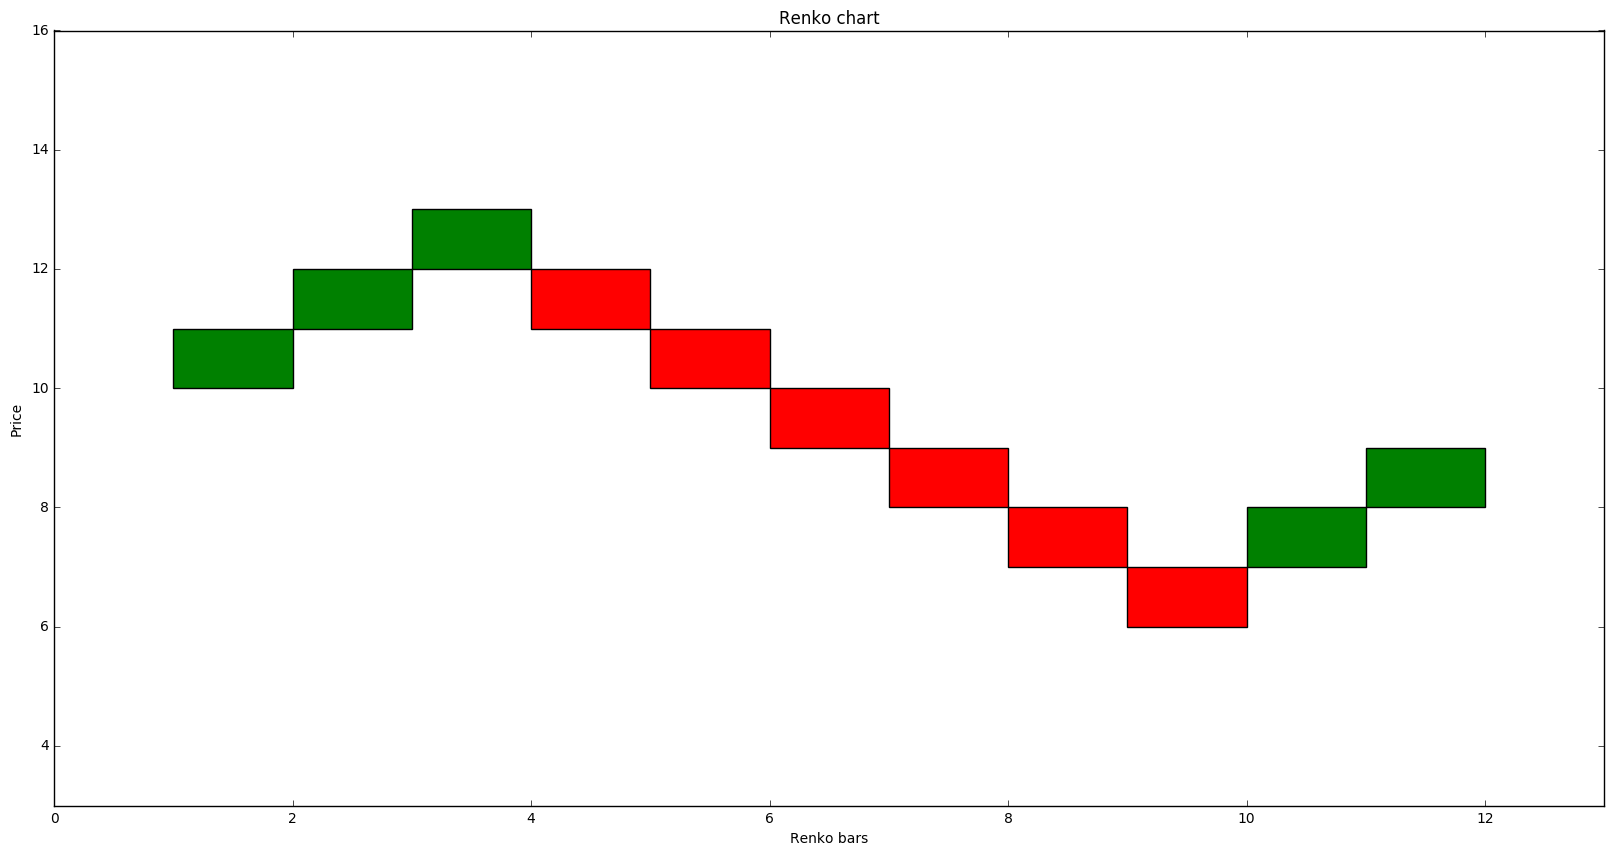

In [2]:
renko_obj = pyrenko.renko()
print('Set brick size (manual mode): ', renko_obj.set_brick_size(auto = False, brick_size = 1.0))

# Emulation that how it will be going when data is streaming from provider/exchange
print('Created renko bars: ', renko_obj.do_next(10.0))
print('Created renko bars: ', renko_obj.do_next(10.5))
print('Created renko bars: ', renko_obj.do_next(13.0))
print('Created renko bars: ', renko_obj.do_next(5.5))
print('Created renko bars: ', renko_obj.do_next(9.5))

print('Renko bar prices: ', renko_obj.get_renko_prices())
print('Renko bar directions: ', renko_obj.get_renko_directions())
print('Renko bar evaluation: ', renko_obj.evaluate())

if len(renko_obj.get_renko_prices()) > 1:
    renko_obj.plot_renko()

### Example 2. Renko chart using history data and auto-brick-size (ATR approach)

Set brick size to optimal:  12.928911141291287
Renko bar prices:  [555.17, 542.2410888587086, 529.3121777174173, 555.1699999999998, 529.3121777174173, 555.1699999999998, 568.0989111412912, 581.0278222825825, 593.9567334238739, 606.8856445651652, 619.8145557064565, 632.7434668477479, 645.6723779890392, 658.6012891303305, 671.5302002716219, 645.6723779890393, 632.743466847748, 658.6012891303305, 632.743466847748, 619.8145557064566, 606.8856445651653, 593.956733423874, 619.8145557064565, 632.7434668477479, 606.8856445651653, 632.7434668477479, 606.8856445651653, 632.7434668477479, 645.6723779890392, 658.6012891303305, 671.5302002716219, 684.4591114129132, 697.3880225542046, 710.3169336954959, 723.2458448367872, 736.1747559780786, 749.1036671193699, 762.0325782606612, 774.9614894019526, 749.10366711937, 736.1747559780787, 723.2458448367873, 710.316933695496, 697.3880225542047, 723.2458448367872, 736.1747559780786, 749.1036671193699, 762.0325782606612, 736.1747559780787, 723.2458448367873, 

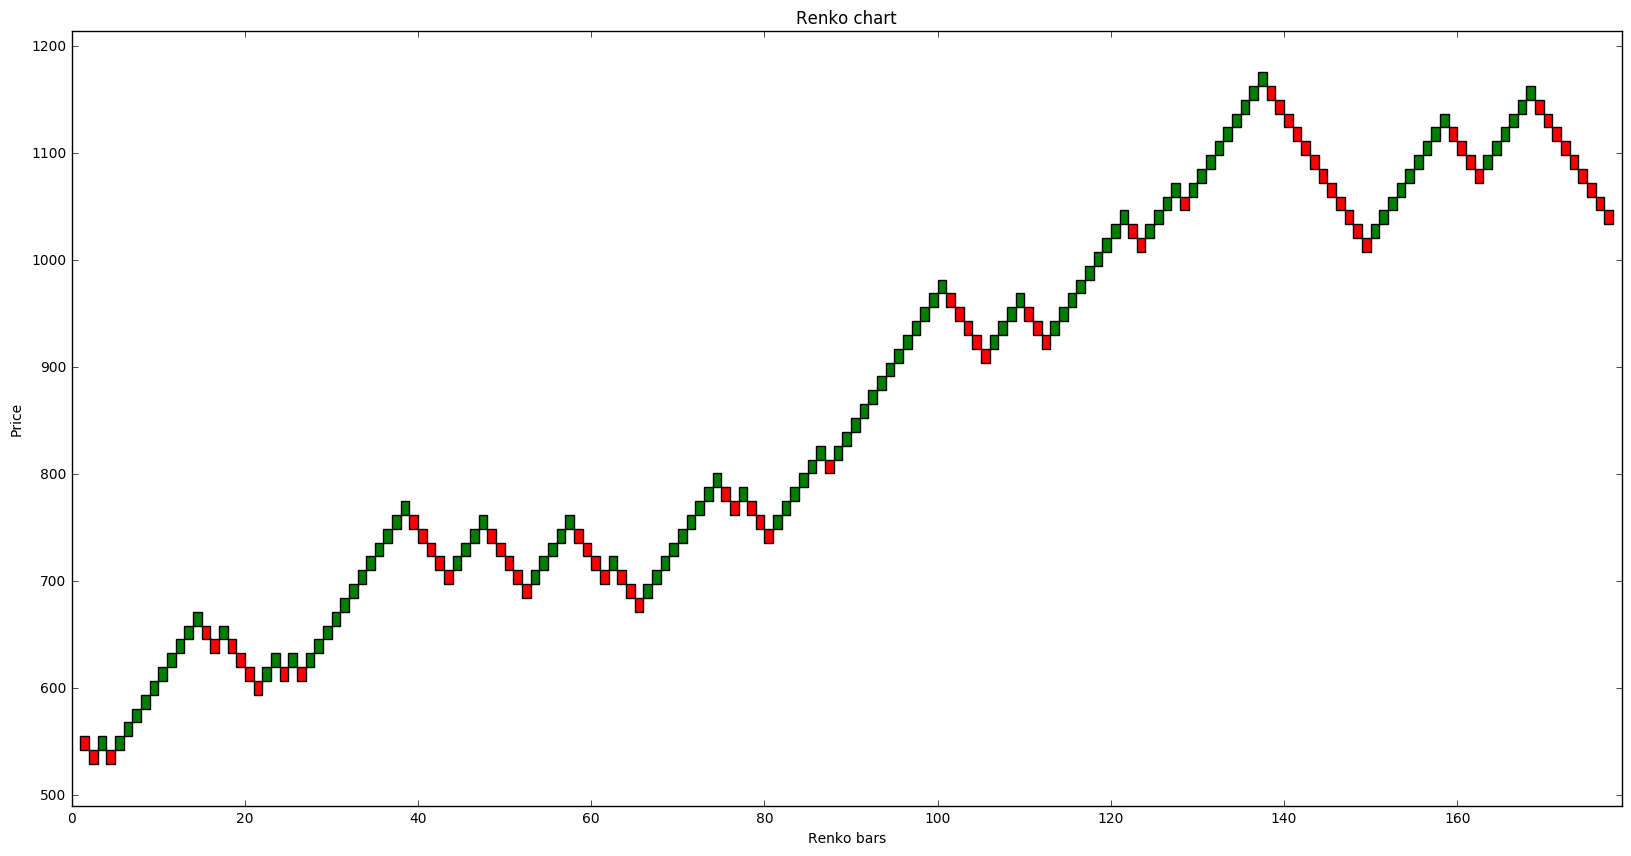

In [3]:
years_ago = 3
# Get data for last years
data = quandl.get("WIKI/GOOG",
                    trim_start = dt.datetime.now() - relativedelta(years = years_ago), 
                    trim_end = dt.datetime.now)

# Get optimal brick size based
optimal_brick = pyrenko.renko().set_brick_size(auto = True, HLC_history = data[["High", "Low", "Close"]])

# Build Renko chart
renko_obj_atr = pyrenko.renko()
print('Set brick size to optimal: ', renko_obj_atr.set_brick_size(auto = False, brick_size = optimal_brick))
renko_obj_atr.build_history(prices = data.Close)
print('Renko bar prices: ', renko_obj_atr.get_renko_prices())
print('Renko bar directions: ', renko_obj_atr.get_renko_directions())
print('Renko bar evaluation: ', renko_obj_atr.evaluate())

if len(renko_obj_atr.get_renko_prices()) > 1:
    renko_obj_atr.plot_renko()

### Example 3. Yet another approach to define brick size by score function optimization
It would be good to measure a quality of Renko chart. Let’s assume a simple strategy which uses these trend following rules: your position should be “long” while the current brick is green (light). Change to the “short” position if the color of brick has been changed. Using this logic, we have the following parameters:

1. balance is a sum of positive and negative deals. If the current brick has the same direction as the previous one, the balance value should be increased by +1. If the direction has been changed, the balance value should be decreased -2. Positive value is good.

2. sign_changes is a number of that how many times a trend has been changed. Less value is better.

3. price_ratio is a ratio of a number of original price bars to a number of renko bricks. Greater value is better.


#### The score function tries to integrate these parameters into a single value. Greater value is better.
<img src="images/score.png">


If sign_changes is equal to 0, it should be set to 1 before calculation.
Let’s try to visualize this score function in 3D space. Size of sphere corresponds to a score value. Red spheres have score equals to -1 value.
<img src="images/sf_3d.png">

Set brick size to optimal:  12.571733414146138
Renko bar prices:  [555.17, 542.5982665858538, 530.0265331717077, 555.17, 530.0265331717077, 517.4547997575615, 542.5982665858538, 555.17, 567.7417334141461, 580.3134668282922, 592.8852002424384, 605.4569336565845, 618.0286670707306, 630.6004004848768, 643.1721338990229, 655.7438673131691, 668.3156007273152, 643.1721338990229, 630.6004004848768, 655.7438673131691, 630.6004004848768, 618.0286670707306, 605.4569336565845, 592.8852002424384, 618.0286670707306, 630.6004004848768, 605.4569336565845, 630.6004004848768, 605.4569336565845, 630.6004004848768, 643.1721338990229, 655.7438673131691, 668.3156007273152, 680.8873341414613, 693.4590675556075, 706.0308009697536, 718.6025343838998, 731.1742677980459, 743.746001212192, 756.3177346263382, 768.8894680404843, 743.746001212192, 731.1742677980459, 718.6025343838998, 706.0308009697536, 731.1742677980459, 743.746001212192, 756.3177346263382, 731.1742677980459, 718.6025343838998, 706.0308009697536, 

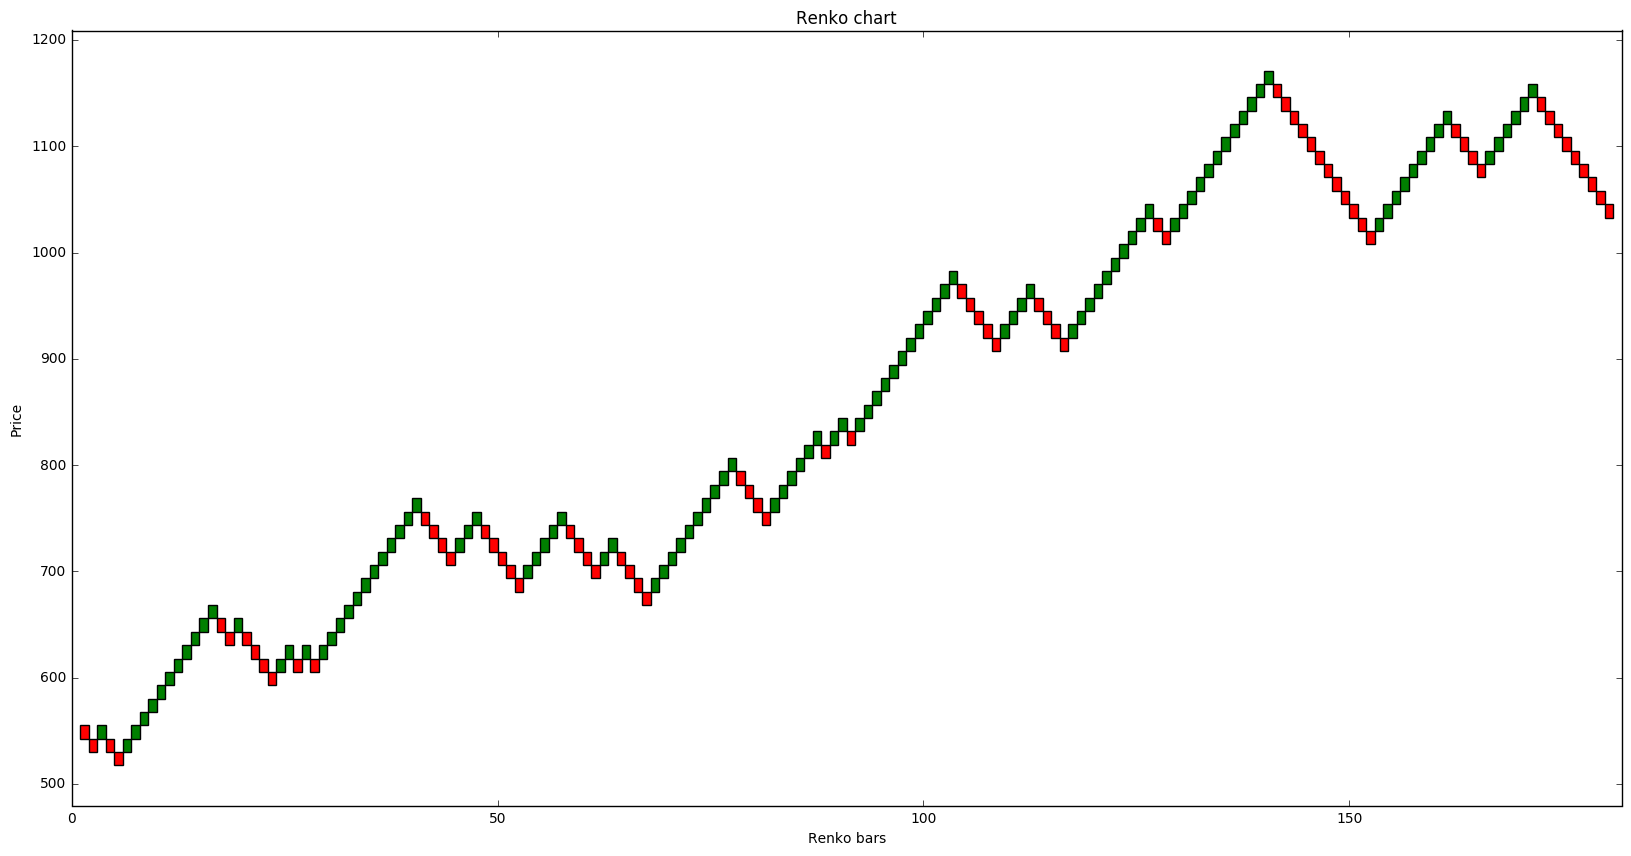

In [4]:
# Function for optimization
def evaluate_renko(brick, history, column_name):
    renko_obj = pyrenko.renko()
    renko_obj.set_brick_size(brick_size = brick, auto = False)
    renko_obj.build_history(prices = history)
    return renko_obj.evaluate()[column_name]

# Get ATR values (it needs to get boundaries)
# Drop NaNs
atr = talib.ATR(high = np.double(data.High),
                low = np.double(data.Low),
                close = np.double(data.Close),
                timeperiod = 14)
atr = atr[np.isnan(atr) == False]

# Get optimal brick size as maximum of score function by Brent's (or similar) method
# First and Last ATR values are used as the boundaries
optimal_brick_sfo = opt.fminbound(lambda x: -evaluate_renko(brick = x, 
                                                            history = data.Close, column_name = 'score'), 
                                  np.min(atr), np.max(atr), disp=0)
# Build Renko chart
renko_obj_sfo = pyrenko.renko()
print('Set brick size to optimal: ', renko_obj_sfo.set_brick_size(auto = False, brick_size = optimal_brick_sfo))
renko_obj_sfo.build_history(prices = data.Close)
print('Renko bar prices: ', renko_obj_sfo.get_renko_prices())
print('Renko bar directions: ', renko_obj_sfo.get_renko_directions())
print('Renko bar evaluation: ', renko_obj_sfo.evaluate())

if len(renko_obj_sfo.get_renko_prices()) > 1:
    renko_obj_sfo.plot_renko()

Score value is not the same. This approach has greater score value than ATR.